<a href="https://colab.research.google.com/github/IamRabindra25/DSSC-course/blob/master/Final_CV_Proj_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> # **Overview**



This project was carried out with  the goal of calssifying images using convolution neural networks with dataset provided that contained 15 categories (office, kitchen, living room, bedroom, store, industrial,tall building, inside city, street, highway, coast, open country, mountain, forest,suburb). Tensorflow and keras libraries were used to carry out the project. 

In the begining , a naive model was built in `section 1 ` with random normal weight initalizer which attained `30%` test accuracy level. This model took 1000 epoch to reach the given baseline accuracy level of 30%.  Then in `section 2`  data augmentation along with layers optmization were performed like batch normalization,dropout, change in size of convolution filters and use of ensemble method.This led to increase in performance of the model and more than `60%` overall test accuracy was observed with very few epochs.Finally, in `section 3` transfer learning using pretrained `VGG19` was implemented which helped to attain an accuracy level of 86% on the test data .





> # **Section 1** :

## Import Packages

In [0]:
import os 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import random
from imutils import paths

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.compat.v2.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from keras.models import load_model,Model
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report,confusion_matrix
from keras.optimizers import SGD

from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC,SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


## Data Preprocessing

In [0]:
data_dir="/content/train"
entries=[f for f in os.listdir(data_dir) if not f.startswith('.')]
entries=sorted(entries)
random.seed(111)
random.shuffle(entries)

# loop over the image folders
# check the length and shape of images

for each_object in entries:
  path=data_dir+'/'+each_object
  images=[cv2.imread(path+'/'+s) for s in os.listdir(path)]
  print(len(images),images[0].shape)


100 (220, 262, 3)
100 (220, 293, 3)
100 (220, 331, 3)
100 (256, 256, 3)
100 (256, 256, 3)
100 (256, 256, 3)
100 (256, 256, 3)
100 (256, 256, 3)
100 (220, 314, 3)
100 (220, 330, 3)
100 (256, 256, 3)
100 (220, 286, 3)
100 (256, 256, 3)
100 (256, 256, 3)
100 (220, 330, 3)


As we have different image shapes in each folder we resize the images to feed the neural networks.So below we load the image to be 64 x 64 pixels and store the image as data variable.

In [0]:
time1 = time.time() 
data = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images(data_dir)))   # data folder with 15 categorical folders
random.seed(110)
random.shuffle(imagePaths)

# loop over the input images
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (64, 64))
    data.append(image)

# extracting the class label from the path 
    label=  imagePath.split(os.path.sep)[-2]
    labels.append(label)

# scaling the raw pixel intensities to the range [0, 1]
data = np.array(data,dtype=float)/255
labels = np.asarray(labels)

# Measuring time elapsed
print('Time elapsed: {:.1f} seconds'.format(time.time() - time1))   
print("Images loading completed")


Time elapsed: 1.9 seconds
Images loading completed


## Splitting Training Set into Training and Validation subsets

Now, we initiate by splitting the above training set into  training and validation set in the ratio of 85:15 .

In [0]:
# partition the data into 85% training and 15% validation
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.15, random_state=111)

Y_train[:5]

array(['Mountain', 'Suburb', 'Street', 'Highway', 'InsideCity'],
      dtype='<U12')

To verify that the data is in the correct form before  building and training the network, let's display training images with  label .

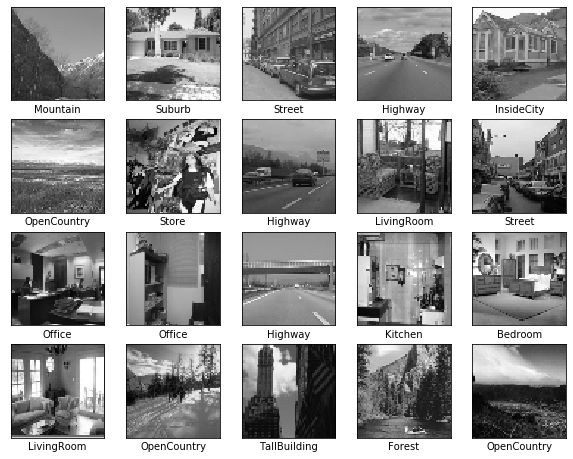

In [0]:
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i,:,:,:], cmap=plt.cm.binary)
    plt.xlabel(Y_train[i])
plt.show()

In [0]:
# convert the labels from integers to vectors 
lb = LabelBinarizer()
Y_train = lb.fit_transform(Y_train)
Y_test= lb.transform(Y_test)



In [0]:

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))



X_train shape: (1275, 64, 64, 3)
Y_train shape: (1275, 15)
X_test shape: (225, 64, 64, 3)
Y_test shape: (225, 15)


## Building the model in Keras

The model is comprised of three convolution blocks with a max pool layer in each of them. There's one and only fully connected layer with 15 units  that is activated by a softmax activation function. The model outputs class probabilities based on catergorical cross entorpy classification.

*Point to be noted, at first weights are randomly initialized with mean=0 and std=0.01 in each layer* So, lets name this as `naive_model`.



In [0]:
sgd=SGD(lr=0.009,momentum=0.9) # momentum dampens oscillation,converges faster

# Uses normal initializer
initializer = tf.random_normal_initializer(mean=0, stddev=0.01, seed=11)   

naive_model= Sequential()
# Adds first convolution layer having 3 x3, 8 filters  with stride 1 .
naive_model.add(layers.Conv2D(8,(3,3),
                strides=1,
                input_shape=(64,64,3),
                activation='relu',
                kernel_initializer=initializer,
                bias_initializer='zeros'))

# Adds maxpooling with pool size 2 X 2,progressively reduces spatial size of input.
naive_model.add(layers.MaxPooling2D((2, 2),strides=2))

# Adds second convolution layer having 3 x3, 16 filters  with stride 1 .
naive_model.add(layers.Conv2D(16, (3, 3),
                  strides= 1,
                  activation='relu',
                  kernel_initializer=initializer,
                  bias_initializer='zeros'))

# Adds maxpooling with pool size 2 X 2,progressively reduces spatial size of input.
naive_model.add(layers.MaxPooling2D((2, 2),strides=2)) 

# Adds third  convolution layer having 3 x3, 32 filters  with stride 1 .
naive_model.add(layers.Conv2D(32,(3,3),
                  strides=1,
                  activation='relu',
                  kernel_initializer=initializer,
                  bias_initializer='zeros'))

  
# Adds first and only fully connected output layer
naive_model.add(Flatten())
naive_model.add(Dense(15,activation='softmax', 
                kernel_initializer=initializer))


# Model summary
print(naive_model.summary())
   

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        4640      
_______________________________________________________

## Compile and Train the model

  `Early stopping` is wrapped in callback function which will end the training when there is no improvement in the validation accuracy for 800 consecutive epochs.
Also to save the best model observed during training as characterized by the perfromance measures drawn from validation dataset, `ModelCheckpoint` is implemented. 

In [0]:
# Earlystopping stops training when no progress in val. accuracy after 800 
# consecutive epochs
es = EarlyStopping(monitor='val_acc', verbose=1, patience=800)

# Records the best model with best accuracy on the validation dataset.
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', 
                     mode='max', save_best_only=True)
# Compiles the model
naive_model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])  

#Fits the model,This callback will stop the training when there is no 
# improvement in the validation loss for 10 consecutive epochs.
naive_history = naive_model.fit(X_train, Y_train, epochs=1000, 
                    validation_data=(X_test, Y_test),
                    batch_size=32,
                    callbacks=[es,mc])


## Evaluate the model

After training the model, lets observe the results by plotting loss and accuracy.

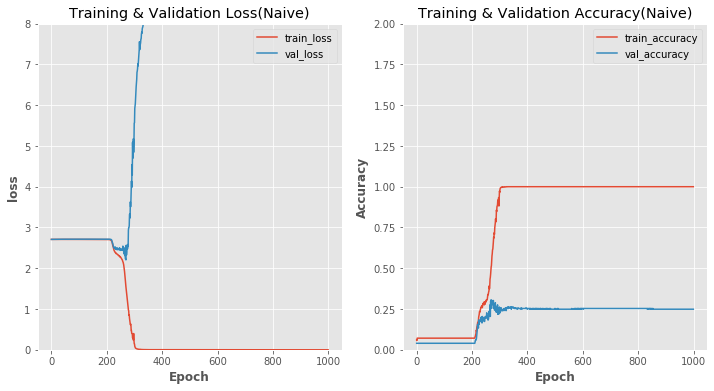

In [0]:
acc = naive_history.history['acc']
val_acc = naive_history.history['val_acc']

loss = naive_history.history['loss']
val_loss = naive_history.history['val_loss']



plt.figure(figsize=(12,6))
plt.style.use("ggplot")
plt.subplot(1, 2, 1)
plt.style.use("ggplot")
plt.plot(loss, label='train_loss')
plt.plot(val_loss, label = 'val_loss')
plt.xlabel('Epoch',weight="bold")
plt.ylabel('loss',weight="bold")
plt.title("Training & Validation Loss(Naive)")
plt.ylim([0, 8])
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.style.use("ggplot")
plt.plot(acc, label='train_accuracy')
plt.plot(val_acc, label = 'val_accuracy')
plt.xlabel('Epoch',weight="bold")
plt.ylabel('Accuracy',weight="bold")
plt.title("Training & Validation Accuracy(Naive)")
plt.ylim([0, 2])
plt.legend(loc='upper right')
plt.show()


In [0]:
test_loss_naive, test_acc_naive = naive_model.evaluate(X_test, Y_test, verbose=2)


225/225 - 0s - loss: 11.9744 - acc: 0.2489


   From the above plots we can observe that our model hardly learnt anything.The validation curve plateaus and is off from the training curve by some good margin. After 1000 epochs ,the training stalls with 24% low accuracy level. This is due to the fact that the weights were initialized randomly with zero mean and std=0.01. This led to having `vanishing gradient` problem with gradients close to `zero` so as a result the  weights remain pretty much the same i.e  unable to update weights in a reasonable amount of time(slow learning rate). This can be addressed by having initialiser that uses the best possible standard deviation for picking random weights.


## Making predictions on unseen test data

Now by using the best model saved as defined by using the validation dataset , we will make predictions with unseen test data and observe the classification report.

First test data preprocessing will be done as before.

In [0]:
time1 = time.time()
train_data=data 
test_data = []
tags = []

# grab the image paths and randomly shuffle them
imgs = sorted(list(paths.list_images("/content/test")))   # data folder with 15 categorical folders
random.seed(110)
random.shuffle(imgs)

# loop over the input images
for imgPath in imgs:
    img = cv2.imread(imgPath)
    img = cv2.resize(img, (64, 64))
    test_data.append(img)

# extracting the class label from the path 
    tag=imgPath.split(os.path.sep)[-2]
    tags.append(tag)

# scaling the raw pixel intensities to the range [0, 1]
test_data = np.array(test_data,dtype=float)/255
tags = np.asarray(tags)

# Measuring time elapsed
print('Time elapsed: {:.1f} seconds'.format(time.time() - time1))   
print("Images loading completed")


Time elapsed: 2.8 seconds
Images loading completed


In [0]:
# convert the labels from integers to vectors 
lb = LabelBinarizer()
train_label = lb.fit_transform(labels)
test_label= lb.transform(tags)



In [0]:
print ("X_train shape: " + str(train_data.shape))
print ("X_train shape: " + str(test_data.shape))

X_train shape: (1500, 64, 64, 3)
X_train shape: (2985, 64, 64, 3)


In [0]:

#loads the best saved model
saved_model = tf.keras.models.load_model('best_model.h5')

saved_model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])  



hist = saved_model.fit(train_data, train_label,
                       validation_data=(test_data,test_label),epochs=10,
                       callbacks=[EarlyStopping(monitor="val_acc",patience=5)])


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 1500 samples, validate on 2985 samples
Epoch 1/10
1500/1500 [==============================] - 6s 4ms/sample - loss: 1.6102 - acc: 0.4947 - val_loss: 2.2024 - val_acc: 0.2888
Epoch 2/10
1500/1500 [==============================] - 6s 4ms/sample - loss: 1.5492 - acc: 0.5013 - val_loss: 2.2952 - val_acc: 0.2881
Epoch 3/10
1500/1500 [==============================] - 6s 4ms/sample - loss: 1.4613 - acc: 0.5347 - val_loss: 2.2900 - val_acc: 0.2921
Epoch 4/10
1500/1500 [==============================] - 6s 4ms/sample - loss: 1.3844 - acc: 0.5487 - val_loss: 2.3655 - val_acc: 0.2888
Epoch 5/10
1500/1500 [==============================] - 6s 4ms/sample - loss: 1.2953 - acc:

In [0]:
test_loss_, test_acc_ =saved_model.evaluate(test_data, test_label)
print("The Model Accuracy for test data is: ", "{:.2%}".format(test_acc_))

2985/2985 [==============================] - 3s 925us/sample - loss: 2.6512 - acc: 0.3062
The Model Accuracy for test data is:  30.62%


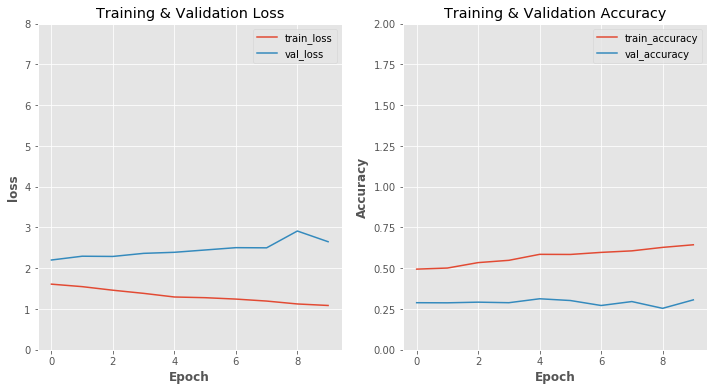

In [0]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']

loss = hist.history['loss']
val_loss = hist.history['val_loss']



plt.figure(figsize=(12,6))
plt.style.use("ggplot")
plt.subplot(1, 2, 1)
plt.style.use("ggplot")
plt.plot(loss, label='train_loss')
plt.plot(val_loss, label = 'val_loss')
plt.xlabel('Epoch',weight="bold")
plt.ylabel('loss',weight="bold")
plt.title("Training & Validation Loss")
plt.ylim([0, 8])
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.style.use("ggplot")
plt.plot(acc, label='train_accuracy')
plt.plot(val_acc, label = 'val_accuracy')
plt.xlabel('Epoch',weight="bold")
plt.ylabel('Accuracy',weight="bold")
plt.title("Training & Validation Accuracy")
plt.ylim([0, 2])
plt.legend(loc='upper right')
plt.show()

After applying the best saved model to the entire training and test data set, we received the above result. In the above plot we can observe that there is still this offset margin between training and validation  accuracy curves nevertheless the margin has slightly decreased owing to increase in the number of training dataset. The validation curve stalls at 30% accuracy level while the training curve shows the improving trend , this points out to the persistent overfitting problem. Furthermore, the training loss curve continues to decrease
and the plot of validation loss is showing a decreasing trend which shows the model capacity of learning further with some changes.
 

## Confusion Matrix

In [0]:
pred = saved_model.predict(test_data, batch_size=32)


In [0]:

def plot_cm(labels, predictions):
  cm = confusion_matrix(labels.argmax(axis=1), predictions.argmax(axis=1))
  plt.figure(figsize=(8,8))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix ')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  

  
        


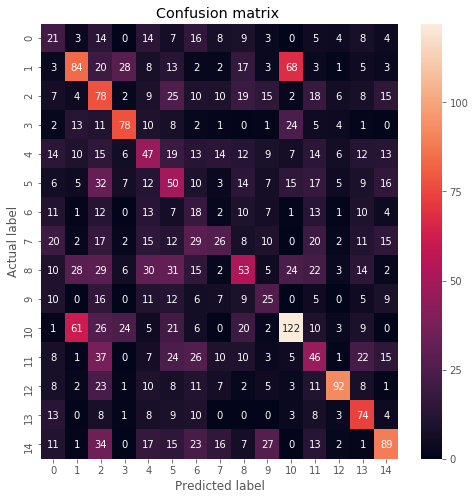

In [0]:


plot_cm(test_label, pred)


From the above confusion matrix , we can observe that our model favors class 10 the most.It has the highest number of all the columns and it managed to learn some but not much . 

We can see in column 0 , the numbers are pretty much close to each other , this indicates that our model did not manage to learn about this class so much,like some guesses.

Similarly, we also can observe that class 2 column has  mostly the higher numbers in compare to the other columns which may indicate of having majority of training images with that label while training but minority of validation images with that particular label.




># **Section: 2**

In this section we will try to improve the above results we got from our naive model in section 1. For this following process will be carried out:

- data augmentation
- batch normalization 
-  changing size or number of convolutional filter
-  manipulating optimization parameters
-  adding dropout
- employing ensemble of networks


## Data Augmentation

Data augmnetation can help reduce the problem of overfitting when we have less number or training examples. It does by generating more training examples by augmenting the samples using random transformations. This is to ensure that our model won't see the same picture twice during training and enrich our model with the capability of generalising well. 

Here we use `ImageDataGenerator` from keras.

In [0]:
image_aug= ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, 
                         zoom_range=[0.5, 1.5],brightness_range=(0.1, 0.9),
                         horizontal_flip=True,vertical_flip=True,
                         fill_mode="nearest")

## Creating the Improved Model

To improve our naive model here we add batch normalization to the layers before the activation, disconnect neurons by adding dropout, increase the filter size in convolution layers and perform data augmentation. Later then we use ensemble method by running the best version of our improved model to get an stable acccuracy.

In [0]:
#sgd=SGD(lr=0.009,momentum=0.9) # momentum dampens oscillation,converges faster

# Uses normal initializer
initializer = tf.keras.initializers.he_normal(seed=111) 
! pip install tensorflow==2.0
model_2= Sequential()
# Adds first convolution layer having 3 x3, 16 filters  with stride 1 .
model_2.add(layers.Conv2D(16,(3,3),
                strides=1,
                input_shape=(64,64,3),
                kernel_initializer=initializer,
                bias_initializer='zeros'))

# normalize activations of input volume before passing to next layer
model_2.add(layers.BatchNormalization()) 
model_2.add(layers.Activation("relu"))
# Adds maxpooling with pool size 2 X 2,progressively reduces spatial size of input.
model_2.add(layers.MaxPooling2D((2, 2),strides=2))
# disconnecting random neurons between layers, reduce overfitting
model_2.add(layers.Dropout(0.20))  



# Adds second convolution layer having 3 x3, 32 filters  with stride 1 .
model_2.add(layers.Conv2D(32, (3, 3),
                  strides= 1,
                  kernel_initializer=initializer,
                  bias_initializer='zeros'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Activation("relu"))
# Adds maxpooling with pool size 2 X 2,progressively reduces spatial size of input.
model_2.add(layers.MaxPooling2D((2, 2),strides=2)) 




# Adds third  convolution layer having 3 x3, 64 filters  with stride 1 .
model_2.add(layers.Conv2D(64,(3,3),
                  strides=1,
                  kernel_initializer=initializer,
                  bias_initializer='zeros'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Activation("relu"))
model_2.add(layers.Dropout(0.20))


# Adds first and only fully connected output layer
model_2.add(Flatten())
model_2.add(Dense(15,activation='softmax'))


# Model summary
print(model_2.summary())

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 62, 62, 16)        448       
_________________________________________________________________
batch_normalization_84 (Batc (None, 62, 62, 16)        64        
_________________________________________________________________
activation_84 (Activation)   (None, 62, 62, 16)        0         
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 31, 31, 16)        0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 29, 29, 32)        4640      
_________________________________________________________________
batch_normalization_85 (Batc (None, 29, 29, 32)      

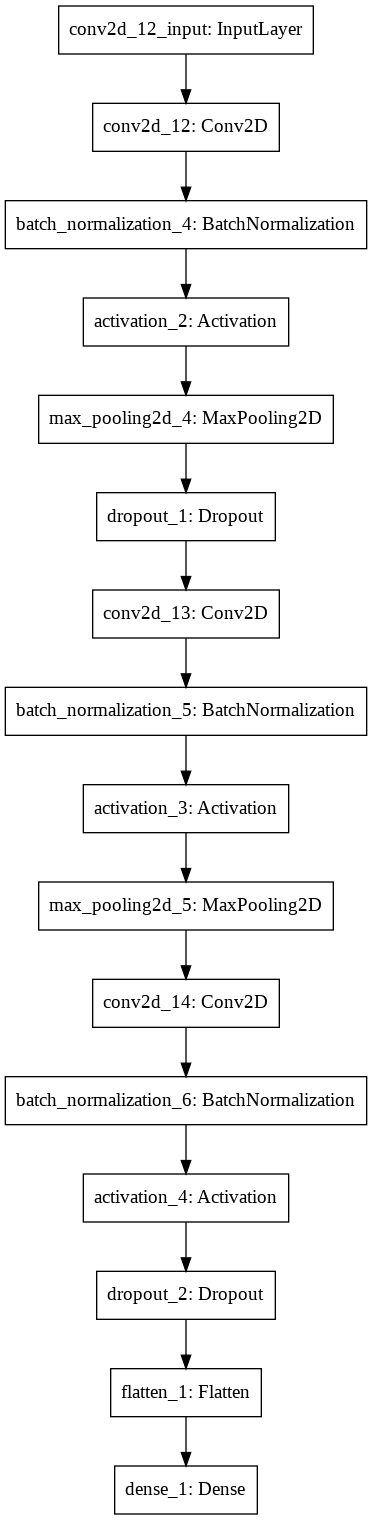

In [0]:
# Plots out the schematic diagram of model_2 .
tf.keras.utils.plot_model(model_2)

## Compile and Fit the improved model

We compile and fit the model with callbacks for earlystop and modelcheckpoint. `Modelcheckpoint` monitors for the maximum of validation accuracy and then the  corresponding model is saved . 

In [0]:
# Earlystopping stops training when no progress in val. accuracy after 120 
# consecutive epochs
es = EarlyStopping(monitor='val_acc', verbose=1, patience=120)

# Records the best model with best accuracy on the validation dataset.
mc = ModelCheckpoint('improved_model.h5', monitor='val_acc', 
                     mode='max', save_best_only=True)

# Compiles the model
model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])  

#Fits the model,The callback will stop the training when there is no improvement 
# in the validation accuracy for 10 consecutive epochs
history_2 = model_2.fit_generator(image_aug.flow(X_train,Y_train,batch_size=32),
                                  validation_data=(X_test, Y_test),
                                  epochs=200,
                                  callbacks=[es,mc]) 

## Evaluating the model

Here we load the best saved model and call evaluate on the test data . 

In [0]:
#loads the best saved model
improved_model = tf.keras.models.load_model('improved_model.h5')

test_loss_improved, test_acc_improved =improved_model.evaluate(test_data, test_label)
print("The Improved Model Accuracy for test data is: ", "{:.2%}".format(test_acc_improved))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
2985/2985 [==============================] - 5s 2ms/sample - loss: 2.0478 - acc: 0.5796
The Improved Model Accuracy for test data is:  57.96%


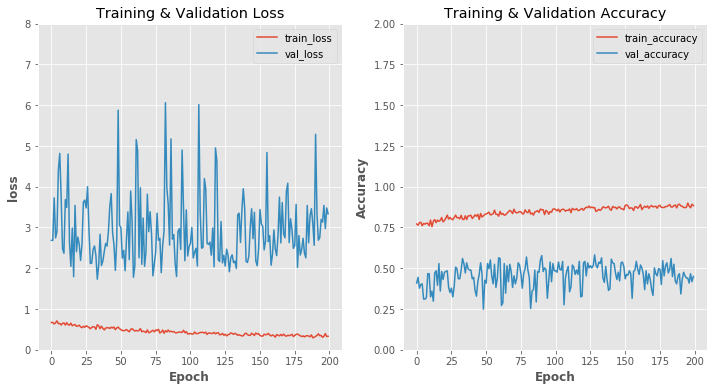

In [0]:
acc = history_2.history['acc']
val_acc = history_2.history['val_acc']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']



plt.figure(figsize=(12,6))
plt.style.use("ggplot")
plt.subplot(1, 2, 1)
plt.style.use("ggplot")
plt.plot(loss, label='train_loss')
plt.plot(val_loss, label = 'val_loss')
plt.xlabel('Epoch',weight="bold")
plt.ylabel('loss',weight="bold")
plt.title("Training & Validation Loss")
plt.ylim([0, 8])
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.style.use("ggplot")
plt.plot(acc, label='train_accuracy')
plt.plot(val_acc, label = 'val_accuracy')
plt.xlabel('Epoch',weight="bold")
plt.ylabel('Accuracy',weight="bold")
plt.title("Training & Validation Accuracy")
plt.ylim([0, 2])
plt.legend(loc='upper right')
plt.show()

 From the above plot we can observe that the val_loss curve is noisy which may be due to data augmentation of the training images which injected variance to our dataset and relatively lacking of sufficent images in the validation test to generalise. The downward trend of train loss also indicates the model capability of further learning . 

The validation accuracy also has this noisy line and it is off by some margin from the training accuracy curve. This overfitting situation can be further addressed by training our model with some more data.

Here we  received the improved accuracy of 57.96 % with 200 epochs.It converged faster in compare to the result in `section 1` when we used the `he` weight initalizer.

## Ensemble of Networks

Now, here we apply the ensemble method on the above improved model. Ensemble method lowers the variance on the final neural network which provides us the confidence in the performance of the model by training multiple models and averaging out their predicitions.



The `fit_model` function loads the previously improved model and returns a fit model on the training dataset. The model is compiled using `adam` optimizer.

In [0]:
#fitting model on dataset
def fit_model(trainX, trainY):
	  #loads the best saved model
			improved_model = tf.keras.models.load_model('improved_model.h5')

			improved_model.compile(optimizer='adam',
														loss='categorical_crossentropy',
														metrics=['accuracy'])  


			improved_model.fit(trainX,trainY,epochs=5,verbose=0)
			return improved_model

Now, the `ensemble_predicitions` function below will make predicition for our test data set.

In [0]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = np.array(yhats)
	# sum across ensemble members
	summed = np.sum(yhats, axis=0)
	# argmax across classes
	result = np.argmax(summed, axis=1)
	return result

	#test_loss_improved, test_acc_improved =improved_model.evaluate(test_data, test_label)

 The `evaluate_n_members` function will return accuracy score from the models.

In [0]:

def evaluate_n_members(members, n_members, testX, testY):
		# make prediction
		yhat = ensemble_predictions(members[:n_members], testX)
		# calculate accuracy
		return accuracy_score(testY.argmax(axis=1), yhat)

In [0]:
# repeated evaluation
  n_members = 10
  scores = list()
  # fit all models
  members = [fit_model(train_data, train_label) for _ in range(n_members)]
  # evaluate ensemble
  for i in range(1, n_members+1):
    score = evaluate_n_members(members, i, test_data, test_label)
    print('> %.3f' % score)
    scores.append(score)
  


> 0.678
> 0.670
> 0.666
> 0.664
> 0.660
> 0.658
> 0.662
> 0.658
> 0.658
> 0.656


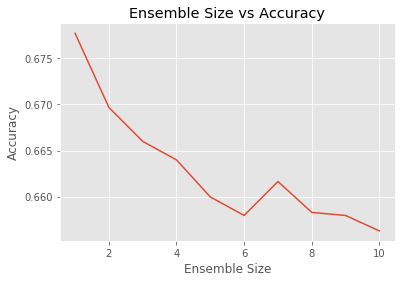

In [0]:
# plot score vs number of ensemble members
x_axis = [i for i in range(1, n_members+1)]
plt.plot(x_axis, scores)
plt.xlabel("Ensemble Size")
plt.ylabel("Accuracy")
plt.title("Ensemble Size vs Accuracy")
plt.show()

In [0]:
# summarize the distribution of scores
print('Mean Accuracy: %.3f, Standard Deviation: %.3f' % (np.mean(scores)*100, np.std(scores)))

Mean Accuracy: 66.295, Standard Deviation: 0.006


The above result was received by training and averaging out the result from ten models. We received the increased accuracy of 66.295% with small standard deviation of 0.6% with an ensemble of 10 models. This suggessts that 99% times the accuracy will fall between 64% to 68% assuming a gaussian distribution. 

 We can observe from the above plot of `ensemble size vs accuracy score` the accuracy fell down and tends towards stability as ensemble size increased. 

># **Section 3:**

In previous section we improved accuracy by adding batch normalization, dropout, default glorot weight initializer and  using enesemble of models. Now, we use existing model with given weights, and tune it to our dataset which is known as 'transfer learning'. The following points are adapted to the `VGG19`. 

1. Freezing weights of all layers except the last dense layer whose weights are then fine tuned based on our training data .

2. Using pre trained network as a feature extractor and training a multiclass linear SVM. 

## Creating the base model from the pre-trained network


We will build the base model from 'VGG16' with weights pre-trained on ImageNet,a large dataset consisting of 1.4 M images and 1000 classes.

So, by specifying the `include_top=False`, it excludes the classification layers at the top i.e the very last layer after the flatten operation.

In [0]:


# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=(64,64,3),include_top=False, weights='imagenet')

## Features Extraction
Here in this step, we will freeze the convolutional base created above with command `layer.trainable = False` to use as a feature extractor and add a classifier then train it. Freezing disallows weight updates during training .


### Freezing the convolution base
By freezing layers ,it stops the weights in the particular layers from being updated.


In [0]:
base_model.trainable = False
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

### Joining the classification layer
 We add the classification layer on the top of the above frozen base. The function `tf.keras.layers.GlobalAveragePooling2D` converts the features to a single  vector per image.

In [0]:
 drop=tf.keras.layers.Dropout(0.25)

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [0]:
prediction_layer=tf.keras.layers.Dense(15,activation='softmax')


##  Building Model
Now, combining  the feature extractor and the classifying layer using a `tf.keras.Sequential` to build the model.

In [0]:
model = tf.keras.Sequential([
  base_model,
  drop,
  global_average_layer,
  prediction_layer
])

In [0]:
 #Callback for printing the LR at the end of each epoch.
 class PrintLR(tf.keras.callbacks.Callback):
     def on_epoch_end(self, epoch, logs=None):
         print('\nLearning rate for epoch {} is {}'.
                                                   format(epoch + 1,
                                                   model.optimizer.lr.numpy()))

## Compiling and Fitting the model

In [0]:

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 512)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 15)                7695      
Total params: 14,722,383
Trainable params: 7,695
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:


# Records the best model with best accuracy on the validation dataset.
mc = ModelCheckpoint('transfer1.h5', monitor='val_accuracy', 
                     mode='max', save_best_only=True)


hist_transfer = model.fit(X_train, Y_train,
                       validation_data=(X_test,Y_test),epochs=200,
                       batch_size=32,callbacks=[mc,PrintLR()])


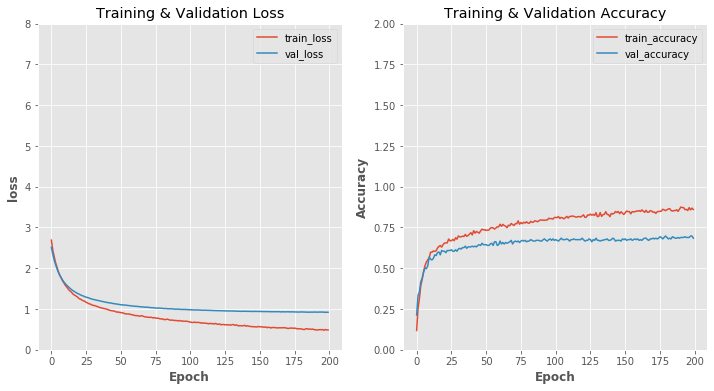

In [0]:
acc = hist_transfer.history['accuracy']
val_acc = hist_transfer.history['val_accuracy']

loss = hist_transfer.history['loss']
val_loss = hist_transfer.history['val_loss']



plt.figure(figsize=(12,6))
plt.style.use("ggplot")
plt.subplot(1, 2, 1)
plt.style.use("ggplot")
plt.plot(loss, label='train_loss')
plt.plot(val_loss, label = 'val_loss')
plt.xlabel('Epoch',weight="bold")
plt.ylabel('loss',weight="bold")
plt.title("Training & Validation Loss")
plt.ylim([0, 8])
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.style.use("ggplot")
plt.plot(acc, label='train_accuracy')
plt.plot(val_acc, label = 'val_accuracy')
plt.xlabel('Epoch',weight="bold")
plt.ylabel('Accuracy',weight="bold")
plt.title("Training & Validation Accuracy")
plt.ylim([0, 2])
plt.legend(loc='upper right')
plt.show()

In [0]:
trans2_model = tf.keras.models.load_model('transfer1.h5')

trans2_model.fit(train_data, train_label)


Train on 1500 samples
1500/1500 [==============================] - 75s 50ms/sample - loss: 0.5830 - accuracy: 0.8213


In [0]:
test_loss_transfer, test_acc_transfer =trans2_model.evaluate(test_data, test_label)
print("The Improved Model Accuracy for test data is: ", "{:.2%}".format(test_acc_transfer))

2985/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

We can observe some overfitting in the plot. The downward trend of the training loss curve indicates us the model still has the capacity of learning . Here, the overall test accuracy was at 71.19 % without data augmentation. 

So, lets re-train the model with some data augmentation .

## Data Augmentation

Data augmentation is performed with the help of `ImageDataGenerator()` function where feature wise centering and standardisation, shifting of height and width with some zoom range are passed.The effect of featurewise will be batches of images with an approximate mean of zero and a standard deviation of one.

In [0]:
image_gen = ImageDataGenerator(
                    featurewise_center=True,
                    featurewise_std_normalization=True,
                    width_shift_range=.15,
                    height_shift_range=.15
                    rotation_range=10,
                    zoom_range=0.5
                    )






Now, the data generator can be used to fit our model by calling the flow() function to retrieve an iterator that returns batches of samples and passing it to the fit_generator() function.

In [0]:
train_iterator = image_gen.flow(X_train,Y_train,batch_size=32)
validation_iterator = image_gen.flow(X_test, Y_test, batch_size=32)
test_iterator=image_gen.flow(test_data,test_label,batch_size=32)
train_full_iterator=image_gen.flow(train_data,train_label,batch_size=32)

In [0]:
# calculate scaling statistics on the training dataset
image_gen.fit(X_train)

In [0]:
#saves the best model whose weights can be used to resume the training.
mc = ModelCheckpoint('transfer_aug.h5', monitor='val_accuracy', 
                     #mode='max', save_best_only=True)


red_lr= ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=5, min_lr=0.000001)

hist_aug = model.fit_generator(train_iterator,
                                  validation_data=validation_iterator,
                                  epochs=25,
                                  callbacks=[red_lr,PrintLR()])

Epoch 1/25
39/40 [============================>.] - ETA: 4s - loss: 1.0648 - accuracy: 0.6702
Learning rate for epoch 1 is 0.0005000000237487257
40/40 [==============================] - 173s 4s/step - loss: 1.0646 - accuracy: 0.6698 - val_loss: 1.2445 - val_accuracy: 0.6444
Epoch 2/25
39/40 [============================>.] - ETA: 4s - loss: 1.0665 - accuracy: 0.6508
Learning rate for epoch 2 is 0.0005000000237487257
40/40 [==============================] - 174s 4s/step - loss: 1.0599 - accuracy: 0.6525 - val_loss: 1.1702 - val_accuracy: 0.6444
Epoch 3/25
39/40 [============================>.] - ETA: 4s - loss: 1.0890 - accuracy: 0.6444
Learning rate for epoch 3 is 0.0005000000237487257
40/40 [==============================] - 175s 4s/step - loss: 1.0953 - accuracy: 0.6408 - val_loss: 1.1191 - val_accuracy: 0.6933
Epoch 4/25
39/40 [============================>.] - ETA: 4s - loss: 1.0374 - accuracy: 0.6613
Learning rate for epoch 4 is 0.0005000000237487257
40/40 [=======================

In [0]:
_, test_aug_transfer =model.evaluate_generator(test_iterator,verbose=0)
print("The Improved Model Accuracy for test data is: ", "{:.2%}".format(test_aug_transfer))

The Improved Model Accuracy for test data is:  86.79%


After applying some data augmentation, the model with transfered learning  attained the overall test accuracy of 86.7%. 

## Fine Tuning Approach

Here , we take the pre-trained VGG16 network and access the last convolution layer and extract features. These extracted features can be used for implementing multicalss SVM. The higher layers in the network contain features increasingly close to the dataset on which the model was trained so these features can be used to work with our new dataset.

We have set layer number `15` as the marker and from this layer onwards we fine tune. So we freeze the layers before layer number 15 . 

In [0]:
base_model.trainable = True

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [0]:

# Fine-tune from this layer onwards
fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 512)         0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 15)                7695      
Total params: 14,722,383
Trainable params: 7,087,119
Non-trainable params: 7,635,264
_________________________________________________________________


In [0]:
mc = ModelCheckpoint('transfer_fine.h5', monitor='val_accuracy', 
                     mode='max', save_best_only=True)


red_lr= ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=5, min_lr=0.000001)
fine_hist = model.fit(X_train,Y_train,
                                  validation_data=(X_test,Y_test),
                                  epochs=30,
                                  callbacks=[mc,red_lr,PrintLR()])

Train on 1275 samples, validate on 225 samples
Epoch 1/30
1248/1275 [============================>.] - ETA: 1s - loss: 1.1265 - accuracy: 0.6426
Learning rate for epoch 1 is 9.999999747378752e-06
1275/1275 [==============================] - 102s 80ms/sample - loss: 1.1232 - accuracy: 0.6447 - val_loss: 1.0686 - val_accuracy: 0.6844
Epoch 2/30
1248/1275 [============================>.] - ETA: 1s - loss: 0.8389 - accuracy: 0.7292
Learning rate for epoch 2 is 9.999999747378752e-06
1275/1275 [==============================] - 100s 79ms/sample - loss: 0.8373 - accuracy: 0.7310 - val_loss: 0.9399 - val_accuracy: 0.6844
Epoch 3/30
1248/1275 [============================>.] - ETA: 1s - loss: 0.6817 - accuracy: 0.7740
Learning rate for epoch 3 is 9.999999747378752e-06
1275/1275 [==============================] - 100s 78ms/sample - loss: 0.6880 - accuracy: 0.7733 - val_loss: 0.8828 - val_accuracy: 0.7244
Epoch 4/30
1248/1275 [============================>.] - ETA: 1s - loss: 0.6260 - accuracy: 0

In [0]:
model.fit(train_data, train_label)


Train on 1500 samples
1500/1500 [==============================] - 103s 68ms/sample - loss: 0.1372 - accuracy: 0.9680


In [0]:
_,test_acc_fine=model.evaluate(test_data,test_label)
print("The Improved Model Accuracy for test data is: ", "{:.2%}".format(test_acc_fine))

2985/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## SVM as classifier

Here, we will train a linear SVM classifier on the features extracted from the fine tuned convolutional base. To train this classifier, we use LinearSVC().  k-fold cross-validation was used to estimate the error of the classifier. 

lets start by extracting the features and making it ready for to pass on to SVM classifier.



In [0]:

batch_size = 32
image_gen = ImageDataGenerator(
                    featurewise_center=True,
                    featurewise_std_normalization=True,
                    )


def extract_features(data,label, size):
  # shape equal to the output of the convolutional base
    features = np.zeros(shape=(size, 2, 2, 512))  
    labels = np.zeros(shape=(size, 15))
    generator = image_gen.flow(data,label,batch_size = batch_size)
    image_gen.fit(data)
    
    i = 0
    for data_batch, label_batch in generator:
        features_batch = base_model.predict(data_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = label_batch
        i += 1
        if i * batch_size >= size:
            break
    return features, labels
    


In [0]:
    
train_features, train_labels = extract_features(train_data,train_label,1500)  
test_features, test_labels = extract_features(test_data,test_label,2985)

In [0]:
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)

(1500, 2, 2, 512)
(2985, 2, 2, 512)
(1500, 15)


In [0]:
# Reshapping to pass to SVM
train_features=train_features.reshape(1500,2*2*512)
test_features=test_features.reshape(2985,2*2*512)
train_labels=np.argmax(train_labels, axis=1)
test_labels=np.argmax(test_labels,axis=1)

In [0]:

p = Pipeline([('s', StandardScaler()),
              ('clf', LinearSVC( max_iter=10000))])

param_grid = {'clf__C': [1e3, 5e3, 1e4, 5e4, 1e5] }

In [0]:
grid = GridSearchCV(p, param_grid,cv=5)

In [0]:
grid.fit(train_features, train_labels)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('s',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        LinearSVC(C=1.0, class_weight=None,
                                                  dual=True, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='squared_hinge',
                                                  max_iter=10000,
                                                  multi_class='ovr',
                                                  penalty='l2',
                                                  random_state=None, tol=0.0001,
                                      

In [0]:
print(grid.best_params_)

{'clf__C': 1000.0}


## Evaluation

In [0]:
print(np.mean(cross_val_score(clf, train_features, train_labels, cv=5)))

0.8926666666666666


In [0]:
p.fit(train_features, train_labels)

In [0]:

print("\nAccuracy score (mean):")
print(np.mean(cross_val_score(p, train_features, train_labels)))



Accuracy score (mean):
0.8806666666666667


In [0]:
y_pred = clf.predict(test_features)

In [0]:
print("Accuracy: {0:0.1f}%".format(accuracy_score(test_labels,y_pred)*100))

Accuracy: 82.1%


Using SVM as classifier also provided us a good accuracy level of 82.1 % .

> # **Summary**
Summarising  some of the take away points that were observed during this project:

1. Overfitting prevails when we have small dataset while data augmentation proved to be a great technique to overcome this problem. It was also noticed that data augmentation should be carefully choosen as drastic augmentation of the data did not contribute towards the performance and took lots of epochs ,e.g severe rotation, zooming .

2. Using `HeNormal` or `Glorot Normal` weight intializer gave better result than  `Random Normal` weight initalizer.

3. Normalizing followed by centering provided improved result.

4. Choosing favorable learning rate also played a good role in enhancing performance.'ReduceonPlateau` function was helpful in reducing the learning rate when accuracy stalled during training. During the fine tuning process, low learning rate was choosen so that it did not greatly modify the weights of the fine tuned layers.

5. Feature extraction and fine tuning on pretrained network further enhaned the performance of our model.Transfer learning with SVM as classifier also gave improved result. 

6. Models could be saved and later on their weights could be loaded to resume the training from where it was stopped. This was a handy tool.

